In [1]:
import pandas as pd 
import numpy as np
import itertools

from ydata_profiling import ProfileReport
from ydata_profiling.utils.cache import cache_file
from ydata_profiling.visualisation.plot import timeseries_heatmap
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from arch import arch_model

from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tools.eval_measures import rmse
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import joblib

import pmdarima
from pmdarima.arima import auto_arima

from scipy.stats.distributions import chi2
import scipy.stats

from math import sqrt
import pylab

# sns.set()

In [2]:
pd.options.display.max_columns = None

#### Helper Functions

In [3]:
def boxplot_graph(df, column = 'ASSET', melt_ = True):
    
    if melt_:
        fig, ax = plt.subplots(figsize = (14,8))
        ax = sns.boxplot(data = df, x = 'YEAR', y = column)
        ax.tick_params(axis='x', rotation=45)
        plt.show()
        
    else:
        df_box = pd.melt(df)
        df_box = df_box.loc[df_box['variable'].isin(['ASSET', 'DEPDOM'])]
        df_box['value'] = df_box['value'].astype(float)
        df_box
        
        fig, ax = plt.subplots(figsize = (14,8))
        ax = sns.boxplot(x="variable", y="value", data=df_box)

        plt.show()

        
def get_fdic_distribution_analysis(fdic_desc):
    
    fdic_desc = fdic_desc.iloc[4:-1].reset_index()
    fdic_desc['ASSET'] = fdic_desc['ASSET'] * 1e-6
    fdic_desc['DEPDOM'] = fdic_desc['DEPDOM'] * 1e-6
    
    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize = (14,8))

    fig.suptitle('Assets and Deposits by Percentiles')
    for i, col in enumerate(fdic_desc.columns[1:]):
        #ax[i].set_title('{} Analysis by Selected Percentiles'.format(col))
        sns.barplot(data = fdic_desc, y = col, x = 'index', ax = ax[i])

    plt.show()
    

def get_rates_distribution_analysis(rates):
    
    rates = rates.iloc[4:-1,:-1].reset_index()
    
    fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize = (14,8))

    fig.suptitle('Rates by Percentiles')
    for i, col in enumerate(rates.columns[1:]):
        ax[i].set_title('{} Analysis by Selected Percentiles'.format(col))
        sns.barplot(data = rates, y = col, x = 'index', ax = ax[i])

    plt.show()


def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p
    
    
def augmented_df_with_data(variable):
    """
    Display the adfuller info in a friendlier fashion
    """
    print('Augmented Dickey-Fuller Test')

    df_test = sts.adfuller(variable)

    dfout = pd.Series(df_test[0:4], index = ['ADF test statistic:','p-value:','# lags used:','# observations:'])

    for key, val in df_test[4].items():

        dfout[f'critical value at ({key}):'] = val

    dfout['Best AIC:'] = df_test[5]
    print(dfout)
    
def seasonal_decompose_groomed(data_series, model, title, figsize = (20,8)):
    """
    This function does a little grooming on the seasonal_decompose().plot()
    
    """

    df = seasonal_decompose(data_series, model = model)

    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize= figsize)

    fig.suptitle(title)

    df.observed.plot(ax=ax1)
    df.trend.plot(ax=ax2)
    df.seasonal.plot(ax=ax3)
    df.resid.plot(ax=ax4)

    labels_list = ['Observed', 'Trend', 'Seasonal', 'Residual']

    for num, i in enumerate((ax1,ax2,ax3, ax4)):
        i.set_ylabel(labels_list[num])

        
def get_banks_portfolio_dataframe(df, name_list):

    pivoted = df.loc[df['NAME'].isin(name_list), :]
    tsa_df = pd.pivot_table(data = pivoted, index = ['REPDTE'], columns = ['NAME'], values = ['ASSET'], aggfunc = np.sum)
    tsa_df = tsa_df.iloc[83:].fillna(method = 'ffill')
    tsa_df.columns = [' '.join(col).strip() for col in tsa_df.columns.values]
    tsa_df.columns = tsa_df.columns.str.replace('ASSET ', '', regex = True)
    tsa_df.index = pd.DatetimeIndex(tsa_df.index.values,
                                   freq="Q-DEC")
    tsa_df['GROUPTOT'] = tsa_df.sum(axis = 1)

    return tsa_df


def add_noise_to_feature(df, field_name):

    df[field_name + '_WN'] = np.random.normal(loc = df[field_name].mean(), scale = df[field_name].std(), size = len(df))

    return df


def lagging_columns(df, col_name, lag_order):
    
    df = df.copy()
    
    for lag_ in lag_order:

        df[col_name + '_' + str(lag_)] = df[col_name].shift(lag_)
        
    return df


def validation_estimation(df, df_validation, model_list, model_results, field = 'ASSET', thresh = -10):
    
    if len(model_list) == len(model_results):
        
        thresh = df.index[thresh]
        test = df[thresh:]
                
        for num, mod in enumerate(model_list):
            
            display(test[[field, model_results[num]]])
            mae = mean_squared_error(test[field], test[model_results[num]])
            rmse = np.sqrt(mae).round(2)
            mape = np.round(np.mean(np.abs(test[field] - test[model_results[num]]) / test[field])*100,2)
            
            temp_df = pd.DataFrame({'Approach': [mod], 'MAE': [mae], 'RMSE': [rmse], 'MAPE': [mape]})
            
            df_validation = pd.concat([df_validation, temp_df])
             
    else:
        print('Review the lenght of your lists')
        
    return df_validation.reset_index(drop = True)


def create_gradient_features(df, field_name= "ASSET", fdic= True):
    
    df = df.copy()
    target_map = df[field_name].to_dict()
    
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['weekofyear'] = df.index.isocalendar().week
    
    if fdic == False:
        df['dayofmonth'] = df.index.day
        df['dayofweek'] = df.index.dayofweek
     
    return df

### Data Preparation

To get bank portfolio data, I will use bank names as defined in the FDIC data as opposed to their corresponding RSSDID number.  I noticed that RSSDID numbers can change overtime, so I would like to keep figures consistent over time.

In [4]:
tsa_df = pd.read_csv('kagglex_project_data.csv')
tsa_df = tsa_df.iloc[:,1:]
tsa_df = add_noise_to_feature(tsa_df, 'port_volume')
tsa_df = add_noise_to_feature(tsa_df, 'port_ret')
tsa_df['date'] = pd.to_datetime(tsa_df['date'])
tsa_df.set_index('date', inplace = True)
tsa_df = tsa_df.asfreq('B')
tsa_df = tsa_df.interpolate(method='linear', limit_direction='forward', axis=0)
tsa_df = create_gradient_features(tsa_df, field_name= "port_volume", fdic= False)
# tsa_df

In [5]:
tsa_df.to_csv('tsa_df.csv')

In [6]:
tsa_df.isna().sum().sum()

0

80 Records because there are 40 Business days in the data that are not recorded in the original Yahoo Finance data.

In [7]:
selected_columns = ['port_ret', 'port_volume', 'DGS1',
       'DGS10', 'DGS1MO', 'DGS2', 'DGS20', 'DGS3', 'DGS30', 'DGS3MO', 'DGS5',
       'DGS6MO', 'DGS7', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'roberta_compound', 'roberta_compound_dummy']

lag_order = [1, 3, 8, 10]

for col_name in selected_columns:

    tsa_df = lagging_columns(tsa_df, col_name, lag_order)

In [8]:
pd.__version__

'1.4.4'

In [9]:
tsa_df.index.freq
print(tsa_df.index.freq)

<BusinessDay>


In [10]:
tsa_df.head()

JPM        BAC        WFC          C         BK   JPM_ret  \
date                                                                           
2020-01-03  123.370583  31.855946  48.428188  69.197479  44.766861 -0.013196   
2020-01-06  123.272476  31.810310  48.138084  68.980408  45.185417 -0.000795   
2020-01-07  121.176796  31.600376  47.739208  68.381340  45.639580 -0.017000   
2020-01-08  122.122078  31.919844  47.884251  68.902290  45.693016  0.007801   
2020-01-09  122.567947  31.974606  47.802670  69.527405  45.844398  0.003651   

             BAC_ret   WFC_ret     C_ret    BK_ret  port_ret  port_volume  \
date                                                                        
2020-01-03 -0.020763 -0.006139 -0.018836 -0.012765 -0.009244    99.075588   
2020-01-06 -0.001433 -0.005990 -0.003137  0.009350 -0.001522    98.924841   
2020-01-07 -0.006600 -0.008286 -0.008685  0.010051 -0.006499    98.281903   
2020-01-08  0.010110  0.003038  0.007618  0.001171  0.003793    98.654674   
2020-01-09  0.001716 -0.001704  0.009072  0.003313  0.000638    98.717624   

            quarter  DGS1  DGS10  DGS1MO  DGS2  DGS20  DGS3  DGS30  DGS3MO  \
date                                                                         
2020-01-03        1  1.55   1.80    1.52  1.53   2.11  1.54   2.26    1.52   
2020-01-06        1  1.54   1.81    1.54  1.54   2.13  1.56   2.28    1.56   
2020-01-07        1  1.53   1.83    1.52  1.54   2.16  1.55   2.31    1.54   
2020-01-08        1  1.55   1.87    1.50  1.58   2.21  1.61   2.35    1.54   
2020-01-09        1  1.54   1.85    1.53  1.58   2.17  1.59   2.38    1.54   

            DGS5  DGS6MO  DGS7  month  year  weekday  dayofweek  \
date                                                              
2020-01-03  1.59    1.55  1.71      1  2020      4.0          4   
2020-01-06  1.61    1.56  1.72      1  2020      0.0          0   
2020-01-07  1.62    1.56  1.74      1  2020      1.0          1   
2020-01-08  1.67    1.56  1.78      1  2020      2.0          2   
2020-01-09  1.65    1.56  1.77      1  2020      3.0          3   

            sentiment_bert  vader_neg  vader_neu  vader_pos  vader_compound  \
date                                                                          
2020-01-03        1.000000   0.161692   0.755615   0.082615       -0.456777   
2020-01-06        1.000000   0.101000   0.774000   0.124556        0.108989   
2020-01-07        1.117647   0.095941   0.769529   0.134529        0.201865   
2020-01-08        1.000000   0.148692   0.743385   0.108000       -0.186269   
2020-01-09        1.000000   0.118905   0.753190   0.128000        0.021581   

            vader_compound_dummy  roberta_neg  roberta_neu  roberta_pos  \
date                                                                      
2020-01-03              1.461538     0.448205     0.511571     0.040224   
2020-01-06              2.111111     0.239483     0.669116     0.091400   
2020-01-07              2.117647     0.219394     0.599717     0.180889   
2020-01-08              1.846154     0.286337     0.638517     0.075146   
2020-01-09              2.047619     0.320694     0.536496     0.142810   

            roberta_compound  roberta_compound_dummy  port_volume_WN  \
date                                                                   
2020-01-03         -0.407981                1.230769       68.143413   
2020-01-06         -0.148083                1.888889       72.845731   
2020-01-07         -0.038505                2.000000       90.093904   
2020-01-08         -0.211192                1.538462      134.813935   
2020-01-09         -0.177884                1.666667      100.468529   

            port_ret_WN  dayofyear   sin_day   cos_day  weekofyear  \
date                                                                 
2020-01-03     0.018292          3  0.141120 -0.989992           1   
2020-01-06    -0.009615          6 -0.279415  0.960170           2   
2020-01-07    -0.039852          7  

In [11]:
tsa_df.to_csv('tsa_df_preprocessed.csv')

In [12]:
tsa_df.describe(percentiles=[.25,.5,.6,.65,.7,.75,.8,.85,.90,.95,.99]).style.format("{:,.4f}")

Create validation dataframe

In [13]:
df_validation = pd.DataFrame()

In [14]:
tsa_df['port_ret_adj'] = tsa_df['port_ret'] * 100

fig = px.line(tsa_df, x= tsa_df.index, y=['port_ret_adj', 'DGS1',
       'DGS10', 'DGS1MO', 'DGS2', 'DGS20', 'DGS3', 'DGS30', 'DGS3MO', 'DGS5',
       'DGS6MO', 'DGS7'], title='TSA Group of Banks -- Portfolio Returns vs Rates')
fig.show()

In [15]:
fig = px.line(tsa_df, x= tsa_df.index, y= 'port_volume_WN', title='TSA Group of Banks -- Portfolio Volume White Noise')
fig.show()

In [16]:
fig = px.line(tsa_df, x= tsa_df.index, y=['port_volume'], title='TSA Group of Banks -- Optimized Portfolio Performance')
fig.show()

In [17]:
sent = ['vader_neg', 'vader_neu', 'vader_pos']

fig = px.line(tsa_df, x= tsa_df.index, y=sent, title='TSA Group of Banks -- Vader Sentiment')
fig.show()

In [18]:
sent = ['roberta_neg', 'roberta_neu', 'roberta_pos']

fig = px.line(tsa_df, x= tsa_df.index, y=sent, title='TSA Group of Banks -- Roberta Sentiment')
fig.show()

In [19]:
sent = ['vader_compound', 'roberta_compound']

fig = px.line(tsa_df, x= tsa_df.index, y=sent, title='TSA Group of Banks -- Vader and Roberta Compound')
fig.show()

In [20]:
fig = px.line(tsa_df, x= tsa_df.index, y= 'port_ret_WN', title='TSA Group of Banks -- Portfolio Returns Noise')
fig.show()

### Forecast approaches

These will be our forecasting methods for analysis purposes:
1. Simple Exponential Smoothing
1. Holt-Winters: Double Exponential Smoothing - Additive
1. Holt-Winters: Double Exponential Smoothing - Multiplicative
1. Holt-Winters: Triple Exponential Smoothing - Additive
1. Holt-Winters: Triple Exponential Smoothing - Multiplicative
1. ARIMA
1. SARIMAX
1. LSTM
1. XGBoost


I currently use 10 quarters of prediction data for this exercise.  I would NOT use so many quarters if this model would be productionize.

#### Split Train and Test Data

In [21]:
# tsa_df = tsa_df.dropna()

In [22]:
tsa_df.index[10]

Timestamp('2020-01-17 00:00:00', freq='B')

In [23]:
init_lag = 10
size_ = int(len(tsa_df) * .02) * -1
threshold_period = tsa_df.index[size_]

In [24]:
train_tsa = tsa_df.iloc[(tsa_df.index >= tsa_df.index[init_lag]) & (tsa_df.index  < threshold_period)]
test_tsa = tsa_df[threshold_period:]

In [25]:
print(train_tsa.port_volume.isnull().sum().sum())
print(test_tsa.port_volume.isnull().sum().sum())

0
0


In [26]:
# train_tsa.index[:10]

In [27]:
# test_tsa.index[:10]

I will be using banks as exogenous variables

### Autoregressive Approaches

#### ARIMA With Exogenous: Rates

Exogenous variables:  ['DGS1', 'DGS10', 'DGS1MO', 'DGS2', 'DGS20', 'DGS3', 'DGS30', 'DGS3MO', 'DGS5', 'DGS6MO']


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  952
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -1879.880
Date:                Mon, 23 Oct 2023   AIC                           3765.760
Time:                        07:19:47   BIC                           3780.332
Sample:                    01-17-2020   HQIC                          3771.312
                         - 09-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0608      0.020     -3.107      0.002      -0.099      -0.022
ar.L2          0.0987      0.021      4.747      0.000       0.058       0.140
sigma2         3.0513      0.091     33.705      0.000       2.874       3.229
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               317.57
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

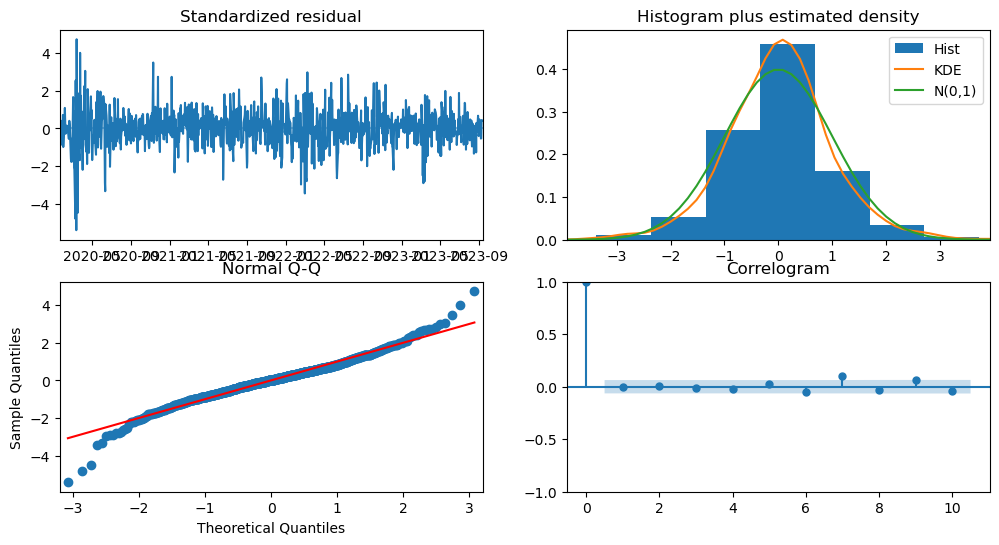

In [28]:
exogenous_mask = list(tsa_df.columns[13:23])
print('Exogenous variables: ', exogenous_mask)

model_arima_exo_best = auto_arima(train_tsa["port_volume"], exogenous= train_tsa[exogenous_mask],
                                  start_p=0, start_q=0, max_p=5, max_q=5, stepwise=True, 
                                  seasonal=False, error_action="ignore", max_order=None)
display(model_arima_exo_best.summary())
model_arima_exo_best.plot_diagnostics(figsize=(12,6));

In [29]:
tsa_df["arimaExo"] = model_arima_exo_best.predict(n_periods = len(test_tsa), exogenous= test_tsa[exogenous_mask],
                                                      index= test_tsa[exogenous_mask].index)

In [30]:
model_list = ['Arima Exogeneous: Rates']
model_results = ["arimaExo"]

df_validation = validation_estimation(tsa_df, df_validation, model_list, model_results, field = 'port_volume', thresh = size_)

port_volume   arimaExo
date                              
2023-09-12    99.562671  97.513875
2023-09-13    99.151097  97.570313
2023-09-14   100.896627  97.570456
2023-09-15   100.411829  97.576021
2023-09-18   100.886348  97.575697
2023-09-19   100.265210  97.576266
2023-09-20    99.516123  97.576199
2023-09-21    98.366782  97.576259
2023-09-22    96.525778  97.576249
2023-09-25    97.154017  97.576256
2023-09-26    95.436199  97.576254
2023-09-27    95.803277  97.576255
2023-09-28    96.397086  97.576255
2023-09-29    95.918122  97.576255
2023-10-02    93.829291  97.576255
2023-10-03    92.083421  97.576255
2023-10-04    92.536817  97.576255
2023-10-05    93.273352  97.576255
2023-10-06    94.341109  97.576255

In [31]:
df_validation

Approach       MAE  RMSE  MAPE
0  Arima Exogeneous: Rates  8.427036   2.9  2.66

In [32]:
# Create the train and test lines
train_trace = go.Scatter(x=train_tsa.index, y=train_tsa['port_volume'], mode='lines', name='Train Data')
test_trace = go.Scatter(x=test_tsa.index, y=test_tsa['port_volume'], mode='lines', name='Test Data')
test_model = go.Scatter(x=tsa_df.index, y=tsa_df["arimaExo"], mode='lines', name='ARIMA:Rates - No Lag')


# Create the figure and add the traces
fig = go.Figure(data=[train_trace, test_trace, test_model])

# Customize the layout
fig.update_layout(
    title='Train vs. Test Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value'),
)

# Show the plot
fig.show()

#### SARIMA With Exogenous: Rates

Exogenous variables:  ['DGS1', 'DGS10', 'DGS1MO', 'DGS2', 'DGS20', 'DGS3', 'DGS30', 'DGS3MO', 'DGS5', 'DGS6MO']


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  952
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -1879.880
Date:                Mon, 23 Oct 2023   AIC                           3765.760
Time:                        07:19:55   BIC                           3780.332
Sample:                    01-17-2020   HQIC                          3771.312
                         - 09-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0608      0.020     -3.107      0.002      -0.099      -0.022
ar.L2          0.0987      0.021      4.747      0.000       0.058       0.140
sigma2         3.0513      0.091     33.705      0.000       2.874       3.229
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               317.57
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

''

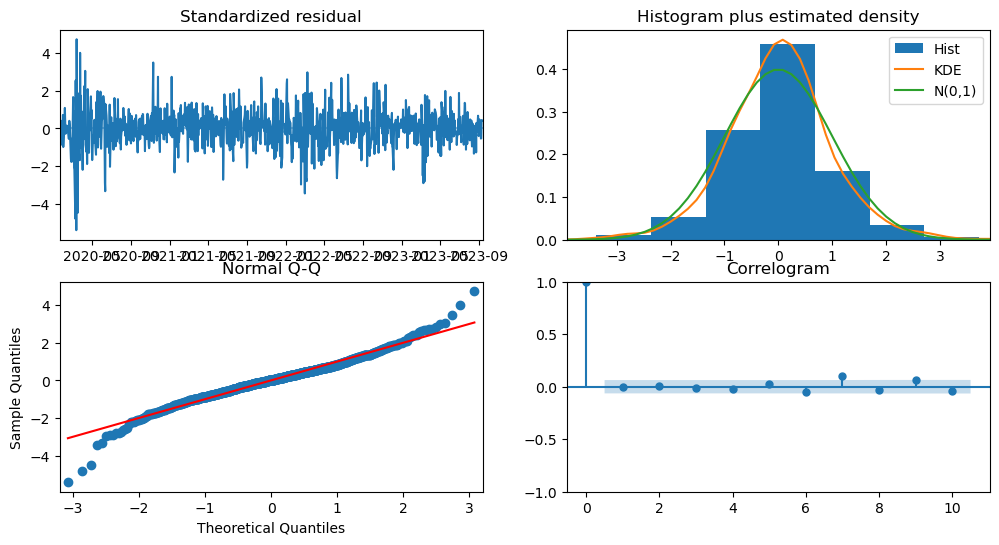

In [33]:
exogenous_mask = list(tsa_df.columns[13:23])
print('Exogenous variables: ', exogenous_mask)

model_sarima_exo_best = auto_arima(train_tsa["port_volume"], exogenous= train_tsa[exogenous_mask],
                                   start_p=0, start_q=0, max_p=5, max_q=5,
                              start_P=0, start_Q=0, max_P=5, max_Q=5, m= 4, maxiter= 500,
                              stepwise=True, seasonal= True, error_action="ignore", max_order=None)
display(model_sarima_exo_best.summary())
model_sarima_exo_best.plot_diagnostics(figsize=(12,6))
;

In [34]:
tsa_df["sarimaExo"] = model_sarima_exo_best.predict(n_periods = len(test_tsa), exogenous= test_tsa[exogenous_mask],
                                                      index= test_tsa[exogenous_mask].index)

In [35]:
model_list = ['Sarima Exogeneous: Rates']
model_results = ["sarimaExo"]

df_validation = validation_estimation(tsa_df, df_validation, model_list, model_results, field = 'port_volume', thresh = size_)

port_volume  sarimaExo
date                              
2023-09-12    99.562671  97.513875
2023-09-13    99.151097  97.570313
2023-09-14   100.896627  97.570456
2023-09-15   100.411829  97.576021
2023-09-18   100.886348  97.575697
2023-09-19   100.265210  97.576266
2023-09-20    99.516123  97.576199
2023-09-21    98.366782  97.576259
2023-09-22    96.525778  97.576249
2023-09-25    97.154017  97.576256
2023-09-26    95.436199  97.576254
2023-09-27    95.803277  97.576255
2023-09-28    96.397086  97.576255
2023-09-29    95.918122  97.576255
2023-10-02    93.829291  97.576255
2023-10-03    92.083421  97.576255
2023-10-04    92.536817  97.576255
2023-10-05    93.273352  97.576255
2023-10-06    94.341109  97.576255

In [36]:
df_validation

Approach       MAE  RMSE  MAPE
0   Arima Exogeneous: Rates  8.427036   2.9  2.66
1  Sarima Exogeneous: Rates  8.427036   2.9  2.66

In [37]:
# Create the train and test lines
train_trace = go.Scatter(x=train_tsa.index, y=train_tsa['port_volume'], mode='lines', name='Train Data')
test_trace = go.Scatter(x=test_tsa.index, y=test_tsa['port_volume'], mode='lines', name='Test Data')
test_model = go.Scatter(x=tsa_df.index, y=tsa_df["sarimaExo"], mode='lines', name='ARIMA:Rates - No Lag')


# Create the figure and add the traces
fig = go.Figure(data=[train_trace, test_trace, test_model])

# Customize the layout
fig.update_layout(
    title='Train vs. Test Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value'),
)

# Show the plot
fig.show()

#### XGBoost: Rates

In [38]:
tss = TimeSeriesSplit(n_splits=5, test_size=size_ * -1, gap=0)

In [39]:
exogenous_mask = list(tsa_df.columns[13:23])
print('Exogenous variables: ', exogenous_mask)
target = "port_volume"

X_train_tuning= train_tsa[exogenous_mask]
y_train_tuning= train_tsa[target]

X_test_tuning= test_tsa[exogenous_mask]
y_test_tuning= test_tsa[target]

model_need_cv = False
model_file_name = "best_xgboost_model_rates_no_lag.pkl" 

if model_need_cv:
    params = {
        'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'min_child_weight': [4, 5],
        'gamma': [i / 10.0 for i in range(3, 6)],
        'subsample': [i / 10.0 for i in range(6, 11)],
        'colsample_bytree': [i / 10.0 for i in range(6, 11)],
        'max_depth': [2, 3, 4]
    }
    # Initialize XGB and GridSearch
    xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror', booster= 'gbtree')
    grid = GridSearchCV(xgb_reg, params)
    grid.fit(X_train_tuning, y_train_tuning)
    gridcv_xgb = grid.best_estimator_
    joblib.dump(gridcv_xgb, model_file_name)
    
else:
    gridcv_xgb = joblib.load("best_xgboost_model_rates_no_lag.pkl")
    

Exogenous variables:  ['DGS1', 'DGS10', 'DGS1MO', 'DGS2', 'DGS20', 'DGS3', 'DGS30', 'DGS3MO', 'DGS5', 'DGS6MO']


[0]	validation_0-rmse:13.35368	validation_1-rmse:1.27809
[99]	validation_0-rmse:1.14168	validation_1-rmse:2.84455
[0]	validation_0-rmse:13.21752	validation_1-rmse:4.46693
[99]	validation_0-rmse:1.11713	validation_1-rmse:2.51448
[0]	validation_0-rmse:13.10880	validation_1-rmse:8.46771
[99]	validation_0-rmse:1.13663	validation_1-rmse:6.07965
[0]	validation_0-rmse:13.01535	validation_1-rmse:12.63056
[99]	validation_0-rmse:1.18243	validation_1-rmse:5.43033
[0]	validation_0-rmse:12.99043	validation_1-rmse:6.01713
[99]	validation_0-rmse:1.18246	validation_1-rmse:4.16094


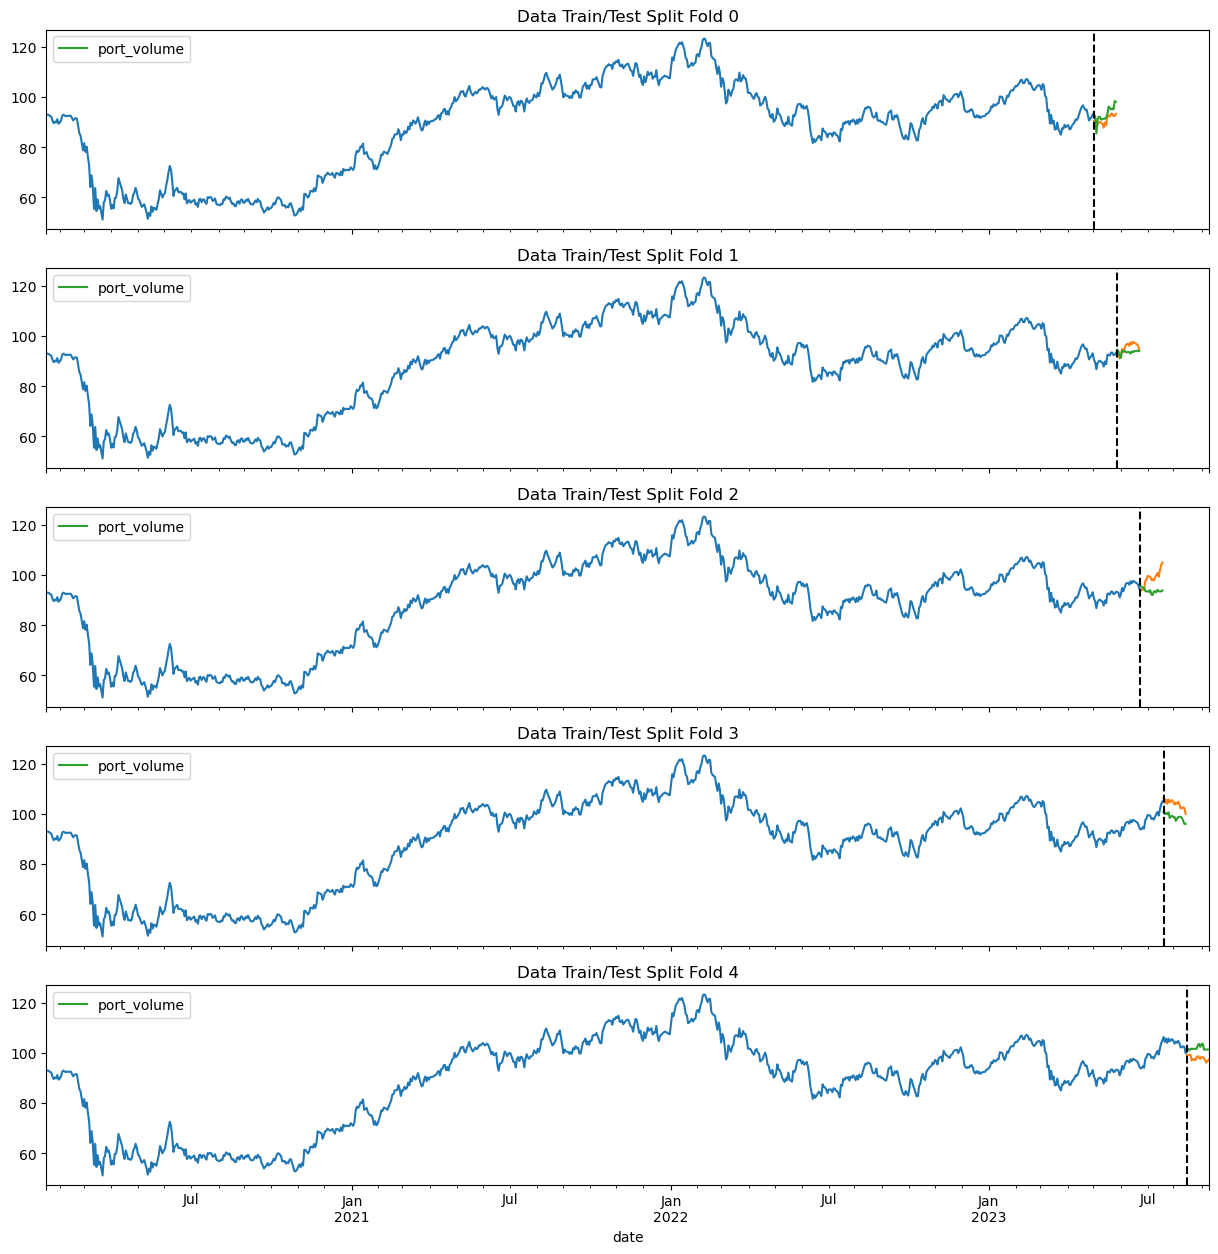

In [40]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
preds = []
scores = []
mapes = []
for train_idx, val_idx in tss.split(train_tsa):
    train = train_tsa.iloc[train_idx]
    val = train_tsa.iloc[val_idx]


    xgb_features_cv = exogenous_mask
    target_cv = target

    X_train = train[xgb_features_cv]
    y_train = train[target_cv]

    X_val = val[xgb_features_cv]
    y_val = val[target_cv]

    reg = gridcv_xgb
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    y_pred_df = pd.DataFrame(index= y_val.index)
    y_pred_df["port_volume"] = y_pred
    
    train["port_volume"].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val["port_volume"].plot(ax=axs[fold],
                         label='Test Set')
    y_pred_df.plot(ax=axs[fold],
                         label='Prediction Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
    
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
    scores.append(score)
    mapes.append(mape)

In [41]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Min score across folds {np.min(scores):0.4f}')
print(f'MAPE across folds {np.mean(mapes):0.4f}')
print(f'Fold scores:{scores}')
print(f'Fold mapes:{mapes}')

Score across folds 4.2060
Min score across folds 2.5145
MAPE across folds 3.9282
Fold scores:[2.8445521503205335, 2.514482690918826, 6.079650396593285, 5.430326928944241, 4.1609426331127555]
Fold mapes:[2.791286229352023, 2.268899040794192, 5.351097267466527, 5.123411598641433, 4.106143208413846]


In [42]:
y_pred = gridcv_xgb.predict(X_test_tuning)
y_pred_df = pd.DataFrame(index= y_test_tuning.index)
y_pred_df["xgboostRates"] = y_pred
tsa_df = pd.merge(tsa_df, y_pred_df, how = 'left', left_index = True, right_index = True)

In [43]:
model_list = ['XGBoost:Rates - No Lag']
model_results = ["xgboostRates"]

df_validation = validation_estimation(tsa_df, df_validation, model_list, model_results, field = 'port_volume', thresh = size_)

port_volume  xgboostRates
date                                 
2023-09-12    99.562671    101.399994
2023-09-13    99.151097    101.399994
2023-09-14   100.896627    101.399994
2023-09-15   100.411829    101.399994
2023-09-18   100.886348    101.399994
2023-09-19   100.265210    101.399994
2023-09-20    99.516123    101.399994
2023-09-21    98.366782    101.399994
2023-09-22    96.525778    101.399994
2023-09-25    97.154017    101.683456
2023-09-26    95.436199    101.683456
2023-09-27    95.803277    101.683456
2023-09-28    96.397086    101.683456
2023-09-29    95.918122    101.683456
2023-10-02    93.829291    101.683456
2023-10-03    92.083421    101.683456
2023-10-04    92.536817    101.683456
2023-10-05    93.273352    101.683456
2023-10-06    94.341109    100.582832

In [44]:
df_validation

Approach        MAE  RMSE  MAPE
0   Arima Exogeneous: Rates   8.427036  2.90  2.66
1  Sarima Exogeneous: Rates   8.427036  2.90  2.66
2    XGBoost:Rates - No Lag  28.959260  5.38  4.76

In [45]:
# Create the train and test lines
train_trace = go.Scatter(x=train_tsa.index, y=train_tsa['port_volume'], mode='lines', name='Train Data')
test_trace = go.Scatter(x=test_tsa.index, y=test_tsa['port_volume'], mode='lines', name='Test Data')
test_model = go.Scatter(x=tsa_df.index, y=tsa_df["xgboostRates"], mode='lines', name='XGBoost:Rates - No Lag')


# Create the figure and add the traces
fig = go.Figure(data=[train_trace, test_trace, test_model])

# Customize the layout
fig.update_layout(
    title='Train vs. Test Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value'),
)

# Show the plot
fig.show()

#### LSTM Univariate

In [71]:
tensor_mask = ['port_volume']

train = train_tsa[tensor_mask]
test = test_tsa[tensor_mask]

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(pd.DataFrame(train))
scaled_test = scaler.transform(pd.DataFrame(test))

length = 3 
batch_size = 1 
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

model = Sequential();
model.add(layers.LSTM(150, return_sequences = True, input_shape=(length,scaled_train.shape[1])))
model.add(layers.LSTM(100))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(scaled_train.shape[1]))
model.compile(loss= 'mse', optimizer= 'adam')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 150)            91200     
                                                                 
 lstm_5 (LSTM)               (None, 100)               100400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 191701 (748.83 KB)
Trainable params: 191701 (748.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

In [73]:
model.fit(generator,epochs=20, verbose = 1,
                    validation_data=validation_generator,
                   callbacks=[early_stop], shuffle=False)


Epoch 1/20
949/949 [==============================] - 13s 10ms/step - loss: 0.0059 - val_loss: 9.9657e-04
Epoch 2/20
949/949 [==============================] - 9s 10ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 3/20
949/949 [==============================] - 9s 9ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 4/20
949/949 [==============================] - 9s 9ms/step - loss: 0.0064 - val_loss: 0.0018


<AxesSubplot:>

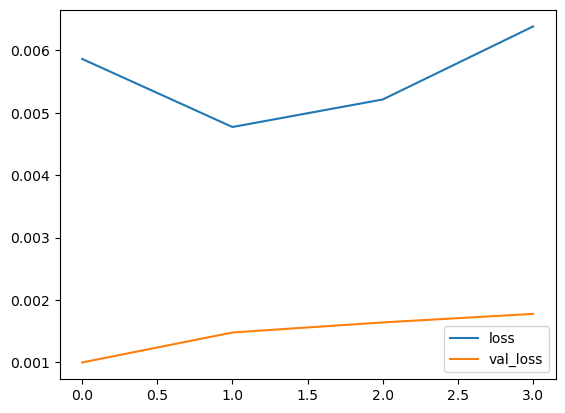

In [74]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [50]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

print(current_batch)

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

[[[0.623124  ]
  [0.63325347]
  [0.64146952]]]
1/1 [==============================] - 0s 23ms/step


In [51]:
true_predictions = scaler.inverse_transform(test_predictions)

In [52]:
true_predictions = pd.DataFrame(data=true_predictions,columns=tensor_mask)
true_predictions["date"] = test_tsa.index
true_predictions.set_index("date", inplace = True)

In [53]:
true_predictions.rename(columns = {"port_volume": "lstmUni"}, inplace = True)

In [54]:
tsa_df = pd.merge(tsa_df, true_predictions.loc[:, "lstmUni"], how = "left", left_index = True, right_index = True)

In [55]:
model_list = ['lstm:Uni - No Lag']
model_results = ["lstmUni"]

df_validation = validation_estimation(tsa_df, df_validation, model_list, model_results, field = 'port_volume', thresh = size_)

port_volume    lstmUni
date                              
2023-09-12    99.562671  96.379121
2023-09-13    99.151097  96.421920
2023-09-14   100.896627  96.411831
2023-09-15   100.411829  96.390167
2023-09-18   100.886348  96.391175
2023-09-19   100.265210  96.390511
2023-09-20    99.516123  96.390098
2023-09-21    98.366782  96.390115
2023-09-22    96.525778  96.390089
2023-09-25    97.154017  96.390080
2023-09-26    95.436199  96.390080
2023-09-27    95.803277  96.390080
2023-09-28    96.397086  96.390080
2023-09-29    95.918122  96.390080
2023-10-02    93.829291  96.390080
2023-10-03    92.083421  96.390080
2023-10-04    92.536817  96.390080
2023-10-05    93.273352  96.390080
2023-10-06    94.341109  96.390080

In [56]:
df_validation

Approach        MAE  RMSE  MAPE
0   Arima Exogeneous: Rates   8.427036  2.90  2.66
1  Sarima Exogeneous: Rates   8.427036  2.90  2.66
2    XGBoost:Rates - No Lag  28.959260  5.38  4.76
3         lstm:Uni - No Lag   8.353347  2.89  2.53

In [57]:
# Create the train and test lines
train_trace = go.Scatter(x=train_tsa.index, y=train_tsa['port_volume'], mode='lines', name='Train Data')
test_trace = go.Scatter(x=test_tsa.index, y=test_tsa['port_volume'], mode='lines', name='Test Data')
test_model = go.Scatter(x=tsa_df.index, y=tsa_df["lstmUni"], mode='lines', name='LSTM:Univariate - No Lag')


# Create the figure and add the traces
fig = go.Figure(data=[train_trace, test_trace, test_model])

# Customize the layout
fig.update_layout(
    title='Train vs. Test Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value'),
)

# Show the plot
fig.show()

#### LSTM: Rates

In [58]:
tensor_mask = ['DGS1', 'DGS10', 'DGS1MO', 'DGS2', 'DGS20', 'DGS3', 'DGS30', 'DGS3MO', 'DGS5', 'DGS6MO', 'port_volume']

train = train_tsa[tensor_mask]

test = test_tsa[tensor_mask]

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(pd.DataFrame(train))
scaled_test = scaler.transform(pd.DataFrame(test))

length = 3 
batch_size = 1 
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

model = Sequential();
model.add(layers.LSTM(150, return_sequences = True, input_shape=(length,scaled_train.shape[1])))
model.add(layers.LSTM(100, return_sequences = False))
model.add(layers.Dense(scaled_train.shape[1]))
model.compile(loss= 'mse', optimizer= 'adam')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 150)            97200     
                                                                 
 lstm_3 (LSTM)               (None, 100)               100400    
                                                                 
 dense_1 (Dense)             (None, 11)                1111      
                                                                 
Total params: 198711 (776.21 KB)
Trainable params: 198711 (776.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

In [60]:
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop], shuffle=False)

Epoch 1/20
949/949 [==============================] - 12s 9ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 2/20
949/949 [==============================] - 8s 9ms/step - loss: 0.0019 - val_loss: 0.0053
Epoch 3/20
949/949 [==============================] - 9s 9ms/step - loss: 0.0030 - val_loss: 0.0054
Epoch 4/20
949/949 [==============================] - 7s 8ms/step - loss: 0.0036 - val_loss: 0.0042


In [61]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

<AxesSubplot:>

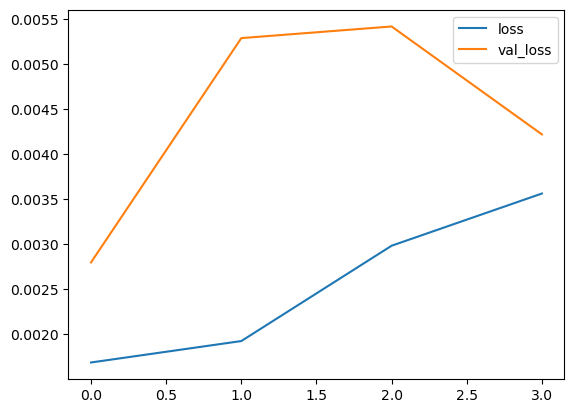

In [62]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [63]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 35ms/step


In [64]:
true_predictions = scaler.inverse_transform(test_predictions)

In [65]:
true_predictions = pd.DataFrame(data=true_predictions,columns=tensor_mask)
true_predictions["date"] = test_tsa.index
true_predictions.set_index("date", inplace = True)

In [66]:
true_predictions.rename(columns = {"port_volume": "lstmRates"}, inplace = True)

In [67]:
tsa_df = pd.merge(tsa_df, true_predictions.loc[:, "lstmRates"], how = "left", left_index = True, right_index = True)

In [68]:
model_list = ['lstmRates:Rates - No Lag']
model_results = ["lstmRates"]

df_validation = validation_estimation(tsa_df, df_validation, model_list, model_results, field = 'port_volume', thresh = size_)

port_volume  lstmRates
date                              
2023-09-12    99.562671  94.629279
2023-09-13    99.151097  94.613227
2023-09-14   100.896627  94.634767
2023-09-15   100.411829  94.627129
2023-09-18   100.886348  94.626306
2023-09-19   100.265210  94.626858
2023-09-20    99.516123  94.626763
2023-09-21    98.366782  94.626746
2023-09-22    96.525778  94.626750
2023-09-25    97.154017  94.626746
2023-09-26    95.436199  94.626746
2023-09-27    95.803277  94.626754
2023-09-28    96.397086  94.626746
2023-09-29    95.918122  94.626746
2023-10-02    93.829291  94.626754
2023-10-03    92.083421  94.626746
2023-10-04    92.536817  94.626746
2023-10-05    93.273352  94.626746
2023-10-06    94.341109  94.626746

In [69]:
df_validation

Approach        MAE  RMSE  MAPE
0   Arima Exogeneous: Rates   8.427036  2.90  2.66
1  Sarima Exogeneous: Rates   8.427036  2.90  2.66
2    XGBoost:Rates - No Lag  28.959260  5.38  4.76
3         lstm:Uni - No Lag   8.353347  2.89  2.53
4  lstmRates:Rates - No Lag  13.510380  3.68  3.13

In [70]:
# Create the train and test lines
train_trace = go.Scatter(x=train_tsa.index, y=train_tsa['port_volume'], mode='lines', name='Train Data')
test_trace = go.Scatter(x=test_tsa.index, y=test_tsa['port_volume'], mode='lines', name='Test Data')
test_model = go.Scatter(x=tsa_df.index, y=tsa_df["lstmRates"], mode='lines', name='LSTM:Rates - No Lag')


# Create the figure and add the traces
fig = go.Figure(data=[train_trace, test_trace, test_model])

# Customize the layout
fig.update_layout(
    title='Train vs. Test Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value'),
)

# Show the plot
fig.show()